In [37]:
import warnings
warnings.filterwarnings('ignore')
import os
import shutil

import numpy as np
import pandas as pd
import math
import itertools

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#SKLEARN

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier


In [38]:
# Read in data from CSV
df_acc = pd.read_csv("acc_4.csv")


def half_int(x):
    val=0.5 * math.ceil(2.0 * x)
    return val

#Cleaning function
def cleaning(df_acc):
    # Rename df_acc column, 'train' -> 'mode'
    df_acc.columns = ['TI', 'TS', 'x', 'y', 'z', 'mode', 'dataset']

    # Drop TS column and replace transportation mode into integer
    df_acc = df_acc.drop(columns=["TS"]).replace({'mode': {'Bus':2, 'Train': 1, 'Walking': 0}})


    # Convert TI value to integer
    df_acc['TI'] = df_acc['TI'].apply(lambda x: half_int(x))

    # Group by and get mean by TI as key
    ndf_acc = df_acc.groupby(['TI', 'dataset'], as_index=False)[['x', 'y', 'z', 'mode']].mean()

    # Clean filtered data
    ndf_acc.columns = ['TI', 'dataset', 'acc_x', 'acc_y', 'acc_z', 'mode']

    
    return ndf_acc

#Cleaning function
def cleaning_tests(df_acc):
    # Rename df_acc column, 'train' -> 'mode'
    df_acc.columns = ['TI', 'TS', 'x', 'y', 'z', 'mode']

    # Drop TS column and replace transportation mode into integer
    df_acc = df_acc.drop(columns=["TS"]).replace({'mode': {'Bus':2,'Train': 1, 'Walking': 0}})


     # Convert TI value to integer
    df_acc['TI'] = df_acc['TI'].apply(lambda x: half_int(x))


    # Group by and get mean by TI as key
    ndf_acc = df_acc.groupby(['TI'], as_index=False)[['x', 'y', 'z', 'mode']].mean()


    # Clean filtered data
    ndf_acc.columns = ['TI', 'acc_x', 'acc_y', 'acc_z', 'mode']
    
    return ndf_acc

In [39]:
df=cleaning(df_acc)

#Magnitude dataframe
df['acc_magnitude']=(df['acc_x']**2+df['acc_y']**2+df['acc_z']**2)**(1/2.0)

#Overlapping
n=10
o=5
X=[df['acc_magnitude'].values[x:x+n] for x in range(0,len(df['acc_magnitude'])-n+1, o) if (df.iloc[x]['dataset'] == df.iloc[x+n-1]['dataset'] and df.iloc[x]['mode'] == df.iloc[x+n-1]['mode'])]
X=np.asarray(X)

Y=[df['mode'].values[x] for x in range(0,len(df['mode'])-n+1, o) if df.iloc[x]['dataset'] == df.iloc[x+n-1]['dataset'] and df.iloc[x]['mode'] == df.iloc[x+n-1]['mode']]
Y=np.asarray(Y)

#THIS IS THE FILE THAT WILL COME FROM API
new_df_acc=pd.read_csv("acc_test_4.csv")

new_df=cleaning_tests(new_df_acc)

df=new_df

#Mag + Overlapping for test

df['acc_magnitude']=(df['acc_x']**2+df['acc_y']**2+df['acc_z']**2)**(1/2.0)

#Overlapping
n=10
o=5
X_new=[df['acc_magnitude'].values[x:x+n] for x in range(0,len(df['acc_magnitude'])-n+1, o) if (df.iloc[x]['mode'] == df.iloc[x+n-1]['mode'])]
X_new=np.asarray(X_new)

Y_new=[df['mode'].values[x] for x in range(0,len(df['mode'])-n+1, o) if df.iloc[x]['mode'] == df.iloc[x+n-1]['mode']]
Y_new=np.asarray(Y_new)

times=[df['TI'].values[x] for x in range(0,len(df['TI'])-n+1, o) if df.iloc[x]['mode'] == df.iloc[x+n-1]['mode']]

times_ref=new_df_acc
times_ref['TI']=new_df_acc['TI'].apply(lambda x: half_int(x))
times_ref=times_ref.loc[times_ref['TI'].isin(times)]
times_ref=times_ref.drop_duplicates(subset='TI', keep="last")['TS']


In [19]:
#K - Cross Validation
# search for an optimal value of K for KNN

# range of k we want to try
k_range = range(1, 31)
# empty list to store scores
k_scores = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X, Y, cv=10, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())


print(k_scores)
k_scores.index(max(k_scores))

[0.7954658759365483, 0.7983348204674858, 0.8239523292992489, 0.8185439757521283, 0.8259421110649543, 0.8239555757995216, 0.8277487797238956, 0.8302703417313981, 0.830091131419217, 0.8291911980464951, 0.8273952236042508, 0.8273903521052779, 0.8273974874116223, 0.8255882215524627, 0.8273939319983972, 0.8273874424949795, 0.8248678283876408, 0.8232426303511241, 0.8221644623648668, 0.8217956704252707, 0.8208986536571027, 0.8181946383342742, 0.8192796187254127, 0.8180154315192208, 0.8174823456830593, 0.8158564948493602, 0.8162191306783854, 0.8147750873570857, 0.8145929639374787, 0.8135115529480764]


7

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30)


# instantiate learning model (k = 2)
knn = KNeighborsClassifier(n_neighbors=7)

# fitting the model
knn.fit(X_train, Y_train)

# predict the response
pred = knn.predict(X_test)

# evaluate accuracy
import sklearn
sklearn.metrics.accuracy_score(Y_test, pred)


0.8492492492492493

Normalized confusion matrix
[[0.03 0.96 0.01]
 [0.06 0.94 0.  ]
 [0.24 0.44 0.32]]


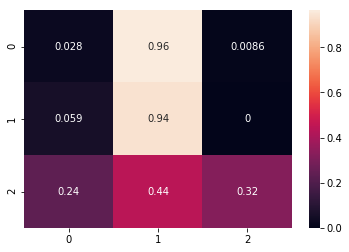

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
  
    sns.heatmap(cm, annot=True)

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_new, pred_new)
np.set_printoptions(precision=2)



plot_confusion_matrix(cnf_matrix, normalize=True, classes=["Walking", "Train", "Bus"],
                      title='Normalized confusion matrix')

plt.show()

In [41]:
#Results
pred_new = knn.predict(X_new)
probs=knn.predict_proba(X_new)
last_acc=sklearn.metrics.accuracy_score(Y_new, pred_new)



In [46]:
#SEND TO UI
last_acc #accuracy of the model
results=np.column_stack([np.transpose(np.column_stack(times_ref)) ,np.transpose(np.column_stack(pred_new))])
results #results 
probs #probability per observation
                                   

array([[0.14, 0.86, 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       ...,
       [0.29, 0.71, 0.  ],
       [0.  , 1.  , 0.  ],
       [0.29, 0.71, 0.  ]])